# Learning Laplacian eigenfunctions in three dimensions

In [1]:
# Load libraries
import logging

import matplotlib.pyplot as plt
import numpy as np
from scipy.special import sph_harm

from klap import (
    ExponentialKernel,
    GaussianKernel,
    PolynomialKernel,
)
from klap.datasets import (
    meshgrid_3d
)

# Set logger
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(levelname)s %(message)s",
)

#### Generate data 

In [2]:
np.random.seed(100)
n = 10000
p = 500

# Learn spherical harmonics
x = np.random.randn(n, 3)
x /= np.sqrt(np.sum(x**2, axis=1))[:, np.newaxis]
X, Y, Z = meshgrid_3d(100)

#### Choose a kernel

In [3]:
# kernel = PolynomialKernel(d=6)
kernel = ExponentialKernel(sigma=10)
# kernel = GaussianKernel(sigma=10)

#### Fit eigenfunctions

In [4]:
help(kernel.fit)

Help on method fit in module klap.kernels.kernel_laplacian:

fit(x, p=None, k=None, L_reg: float = 0, R_reg: float = 0, inverse_L: bool = False) method of klap.kernels.exponential.ExponentialKernel instance
    Estimate Laplacian operator based on data.
    
    Parameters
    ----------
    x: ndarray of size (n, d)
        Data matrix
    p: int (optional, default is None)
        Number of representer points to use
    k: int (optional, default is None)
        Number of eigenvalues to compute. If None, k will be taken as self.k (default is 16)
    L_reg: float (optional, default is 0)
        Regularization parameter for Laplacian matrix
    R_reg: float (optional, default is 0)
        Regularization parameter for Nystrom matrix
    inverse_L: bool (optional, default is False)
        Either to inverse L or R in the GEVD system.
    
    Returns
    -------
    lambdas: ndarray of size (k,)
        Eigenvalues of the Laplacian operator
    alphas: ndarray of size (p, k)
        Ei

In [5]:
kernel.fit(x, p=p, k=16, L_reg=1e-4, R_reg=0)

2023-03-21 18:04:36,546 INFO Distance kernel computation
2023-03-21 18:05:10,594 INFO Inversing R


#### Get eigenfunctions / features map

In [6]:
x_test = np.vstack((X.flatten(), Y.flatten(), Z.flatten())).T
phi = kernel(x_test)

#### Plot eigenfunctions

In [7]:
# Helper functions
def plot_sphere(ax, X, Y, Z, f, **kwargs):
    f /= np.sqrt(np.mean(f**2, axis=0))
    cm = plt.get_cmap('RdBu')(f.reshape(*X.shape))
    ax.plot_surface(X, Y, Z, facecolors=cm, **kwargs)
    ax.set_xlim([-0.8, 0.8])
    ax.set_ylim([-0.8, 0.8])
    ax.set_zlim([-0.8, 0.8])
    ax.set_axis_off()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_zticklabels([])


def get_true_harmonic(x_test, num):
    out = np.zeros((len(x), num))
    phi = np.arccos(x_test[:,2])
    theta = np.arctan2(x_test[:,1], x_test[:,0])
    i = 0
    for i in range(num):
        l = int(np.sqrt(i))
        m = i - l**2 - l
        out[:, i] = np.real(sph_harm(m, l, theta, phi))
    return out

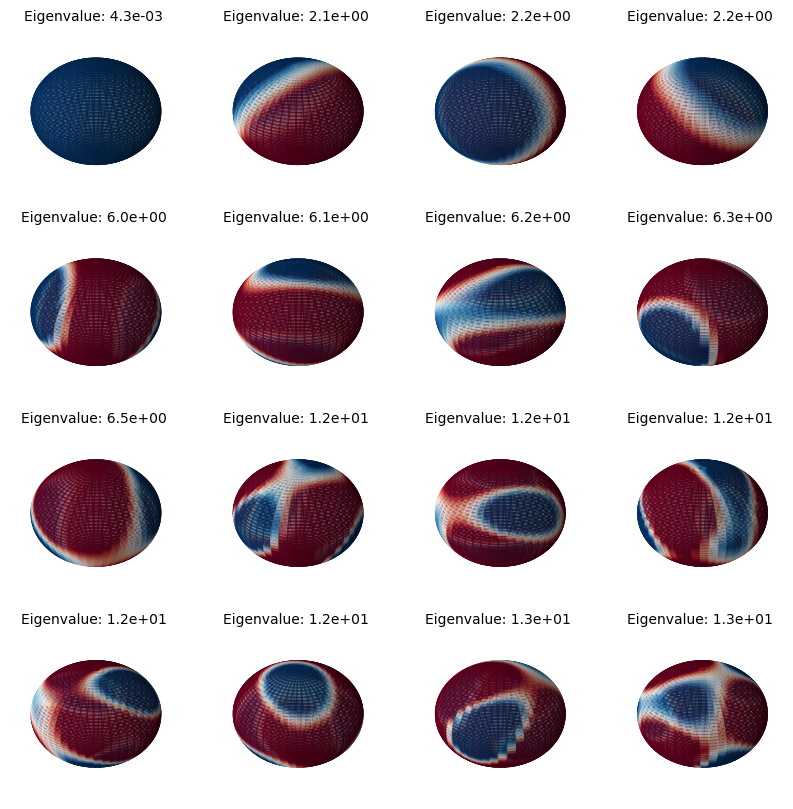

In [8]:
num = 4
fig, axes = plt.subplots(num, num, figsize=(10, 10), subplot_kw={"projection": "3d"})
for i in range(num ** 2):
    plot_sphere(axes[i//num, i%num], X, Y, Z, phi[:, i], alpha=.5)
    axes[i//num, i%num].set_title(f"Eigenvalue: {kernel.eigenvalues[i]:.1e}", fontsize=10)

#### Show ground truth

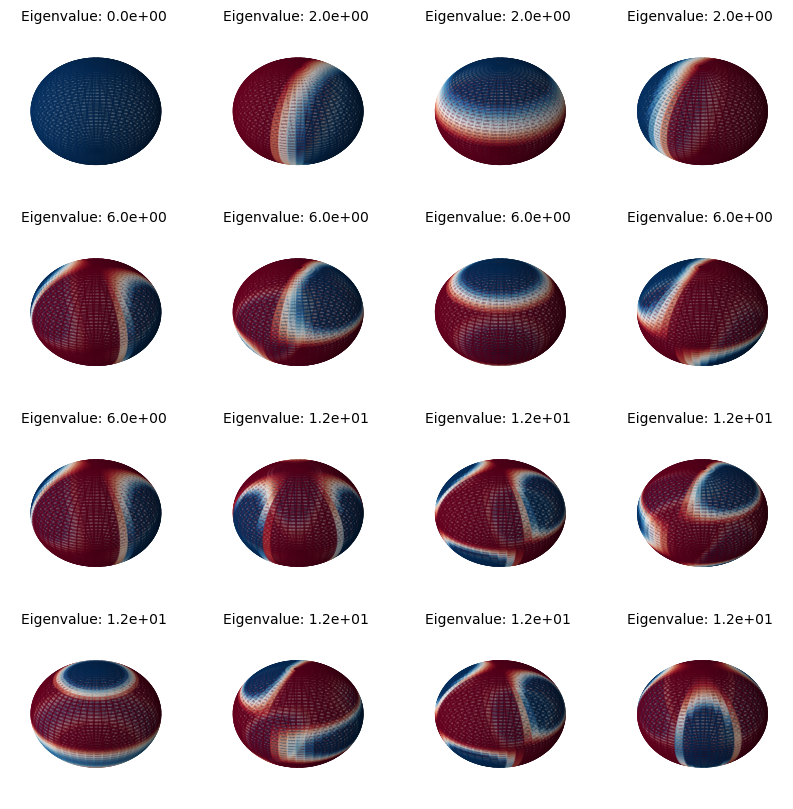

In [9]:
phi_true = get_true_harmonic(x_test, 16)
fig, axes = plt.subplots(num, num, figsize=(10, 10), subplot_kw={"projection": "3d"})
for i in range(num ** 2):
    plot_sphere(axes[i//num, i%num], X, Y, Z, phi_true[:, i], alpha=.5)
    l = int(np.sqrt(i))
    eigenvalue = l * (l + 1)
    axes[i//num, i%num].set_title(f"Eigenvalue: {eigenvalue:.1e}", fontsize=10)